In [1]:
import os
import numpy as np
from astropy.table import Table, Column, join
import matplotlib.pyplot as plt
from astropy import units as u
from edge_pydb import EdgeTable
from edge_pydb.conversion import msd_co
from edge_pydb.plotting import xy2hist
np.seterr(invalid='ignore')

{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

## Spatially resolved SF relations for EDGE, at 7" resolution.
### We use the 'smo' mask for detections but the 'str' mask for considering non-detections.

In [2]:
sspcols = ['Name','ix','iy','mass_ssp_sm','sigstar_sm']
fluxcols = ['Name','ix','iy','flux_Halpha_sm','flux_Hbeta_sm','e_flux_Halpha_sm',
          'flux_sigsfr_sm','EW_Halpha_sm','ZOH_sm','BPT_sm']

try: 
    fluxtab = EdgeTable('edge.pipe3d.hdf5', path='flux_elines_sm', cols=fluxcols)
    ssptab = EdgeTable('edge.pipe3d.hdf5', path='SSP_sm', cols=sspcols)
    cotab = EdgeTable('edge.comom_smo7.hdf5', path='smo')
    conomasktab = EdgeTable('edge.comom_smo7.hdf5', path='str', cols=['Name','ix','iy','emom0_12'])
    print('Working on full EDGE database')
except:
    fluxtab = EdgeTable('NGC4047.pipe3d.hdf5', path='flux_elines_sm', cols=fluxcols)
    ssptab = EdgeTable('NGC4047.pipe3d.hdf5', path='SSP_sm', cols=sspcols)
    cotab = EdgeTable('NGC4047.comom_smo7.hdf5', path='smo')
    conomasktab = EdgeTable('NGC4047.comom_smo7.hdf5', path='str', cols=['Name','ix','iy','emom0_12'])
    print('Working on NGC 4047 data')

Working on full EDGE database


In [3]:
fluxtab.join(ssptab, keys=['Name', 'ix', 'iy'])
fluxtab.join(cotab, keys=['Name', 'ix', 'iy'])
conomasktab['emom0_12'].name = 'emom0max_12'
fluxtab.join(conomasktab, keys=['Name', 'ix', 'iy'])
print(fluxtab.colnames)

['Name', 'ix', 'iy', 'flux_Halpha_sm', 'flux_Hbeta_sm', 'e_flux_Halpha_sm', 'flux_sigsfr_sm', 'EW_Halpha_sm', 'ZOH_sm', 'BPT_sm', 'mass_ssp_sm', 'sigstar_sm', 'ra_off', 'dec_off', 'rad_arc', 'azi_ang', 'mom0_12', 'emom0_12', 'mom1_12', 'emom1_12', 'mom2_12', 'emom2_12', 'sigmol', 'e_sigmol', 'sigmol_fo', 'e_sigmol_fo', 'mom0_13', 'emom0_13', 'mom1_13', 'emom1_13', 'mom2_13', 'emom2_13', 'emom0max_12']


In [4]:
# Apply a 3-sigma cut to both axes
det = (fluxtab['mom0_12']>3*fluxtab['emom0_12']) & (fluxtab['flux_Halpha_sm']>3*fluxtab['e_flux_Halpha_sm'])
codata = fluxtab['mom0_12'][det]
hadata = fluxtab['flux_Halpha_sm'][det]
sig_mol = fluxtab['sigmol'][det]
sig_sfr = fluxtab['flux_sigsfr_sm'][det]
sig_star = fluxtab['sigstar_sm'][det]

# Ratios
t_dep = Column(sig_mol.quantity/sig_sfr.quantity, name='t_dep')
sig_ssfr = Column(sig_sfr.quantity/sig_star.quantity, name='sig_ssfr')

Table([sig_mol,sig_sfr,t_dep,sig_star,sig_ssfr]).pprint(max_width=100)

    sigmol       flux_sigsfr_sm      t_dep      sigstar_sm    sig_ssfr 
solMass / pc2 solMass / (Gyr pc2)     Gyr     solMass / pc2   1 / Gyr  
------------- ------------------- ----------- ------------- -----------
     68.34822           2132.4631 0.032051302     175.56535   12.146264
   122.069786           1250.5819  0.09761039     284.78217    4.391363
    190.01736           267.31152   0.7108461     368.36966   0.7256611
    191.74936            65.26571   2.9379802     383.81113  0.17004642
    102.89037            25.49625     4.03551     333.28067  0.07650084
    11.697756           0.6658555   17.568008     48.072304 0.013851126
    114.60162            2501.796  0.04580774     243.38942   10.278984
     406.7665            4718.179 0.086212605     433.37213   10.887131
    797.65985           2672.9226  0.29842237     608.18384   4.3949256
    747.42053           645.03705    1.158725      630.9911   1.0222602
          ...                 ...         ...           ...     

In [5]:
# Derived quantities for the CO non-detections
ndet = (fluxtab['flux_Halpha_sm']>3*fluxtab['e_flux_Halpha_sm']) & ~det
# Upper limits need to be calculated explicitly since e_sigmol is only the uncertainty for detections
sig_mol_ndet = msd_co(3*fluxtab['emom0max_12'][ndet], name='sig_mol_ul')
sig_sfr_ndet = fluxtab['flux_sigsfr_sm'][ndet]
sig_star_ndet = fluxtab['sigstar_sm'][ndet]

# Ratios
t_dep_ndet = Column(sig_mol_ndet.quantity/sig_sfr_ndet.quantity, name='t_dep_ul')
sig_ssfr_ndet = Column(sig_sfr_ndet.quantity/sig_star_ndet.quantity, name='sig_ssfr_ndet')

Table([sig_mol_ndet,sig_sfr_ndet,t_dep_ndet,sig_star_ndet,sig_ssfr_ndet]).pprint(max_width=100)

  sig_mol_ul     flux_sigsfr_sm    t_dep_ul    sigstar_sm  sig_ssfr_ndet
solMass / pc2 solMass / (Gyr pc2)    Gyr     solMass / pc2    1 / Gyr   
------------- ------------------- ---------- ------------- -------------
    52.223915           1.2484366   41.83145     14.411152     0.0866299
     52.33929             4.38511  11.935685     14.411152    0.30428588
     49.86986           0.9589341  52.005512     14.786302    0.06485287
     49.47098           0.6874263    71.9655     14.411152   0.047700997
     49.32523           1.7158978  28.746017     14.411152   0.119067356
     49.43029           3.8217723  12.933866     14.411152     0.2651955
      47.9812           1.1350198   42.27345     10.756967   0.105514854
    47.370228           2.6739237  17.715624     10.756967      0.248576
    46.999947           1.4031217    33.4967     14.411152   0.097363606
     46.86396           1.0058789   46.59006     14.411152    0.06979865
          ...                 ...        ...       

## Spatially resolved CO vs. Halpha

/opt/local/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:5: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated. Use an explicit list instead.
  """


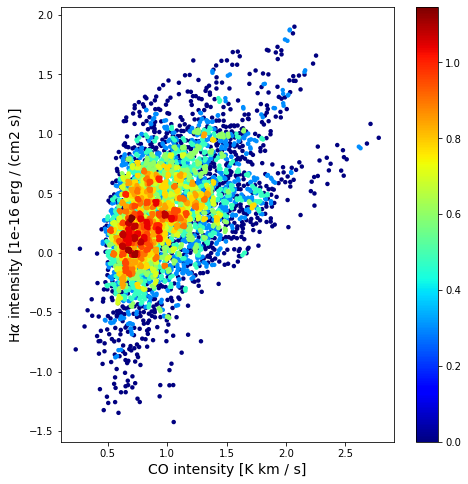

In [6]:
# Make the scatter plot (measured values)
x_det, y_det, z_det, *hist = xy2hist(codata, hadata, log=True)
fig, ax = plt.subplots(figsize=(8,8))
cm = plt.cm.get_cmap('jet')
sc = ax.scatter(x_det, y_det, c=z_det, s=20, edgecolor='', cmap=cm)
plt.xlabel('CO intensity ['+str(codata.unit)+']',fontsize=14)
plt.ylabel(r'H$\alpha$ intensity ['+str(hadata.unit)+']',fontsize=14)
ax.set_aspect('equal')
plt.colorbar(sc)

## Spatially resolved star formation law (extinction corrected)

Excluding 12 invalid values
Number of valid points: 5375


/opt/local/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:14: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated. Use an explicit list instead.
  


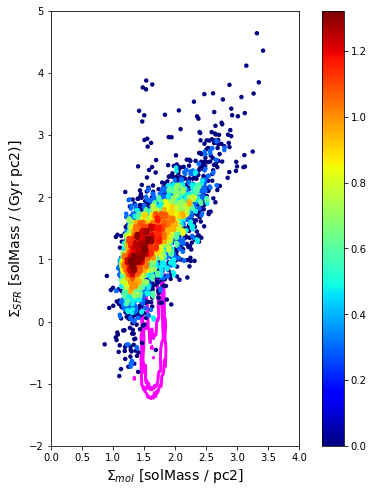

In [7]:
# Select data to plot (must be loggable)
not_nan = (~np.isnan(sig_mol)) & (~np.isnan(sig_sfr)) & (sig_mol>0) & (sig_sfr>0)
print('Excluding {} invalid values'.format(len(np.nonzero(~not_nan)[0])))
print('Number of valid points:',len(np.nonzero(not_nan)[0]))
not_nan_ndet = (~np.isnan(sig_mol_ndet)) & (~np.isnan(sig_sfr_ndet)) & (sig_mol_ndet>0) & (sig_sfr_ndet>0)

x_det, y_det, z_det, *hist = xy2hist(sig_mol[not_nan], sig_sfr[not_nan], log=True)
x_ndet, y_ndet, z_ndet, *hist2 = xy2hist(sig_mol_ndet[not_nan_ndet], 
                                         sig_sfr_ndet[not_nan_ndet], log=True, bins=[50,50])

# Make the scatter plot (physical values)
fig, ax = plt.subplots(figsize=(8,8))
cm = plt.cm.get_cmap('jet')
sc = ax.scatter(x_det, y_det, c=z_det, s=20, edgecolor='', cmap=cm)
ax.contour(hist2[0].transpose(),[10,30,100,300],
           extent=[hist2[1].min(),hist2[1].max(),
                   hist2[2].min(),hist2[2].max()],
           colors='magenta',linewidths=3,zorder=-1)
plt.xlabel(r'$\Sigma_{mol}$ ['+str(sig_mol.unit)+']',fontsize=14)
plt.ylabel(r'$\Sigma_{SFR}$ ['+str(sig_sfr.unit)+']',fontsize=14)
ax.set_aspect('equal')
ax.set_xlim(0,4)
ax.set_ylim(-2,5)
plt.colorbar(sc)

## Depletion time vs. local stellar density

Excluding 12 invalid values
Number of valid points: 5375


/opt/local/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:14: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated. Use an explicit list instead.
  


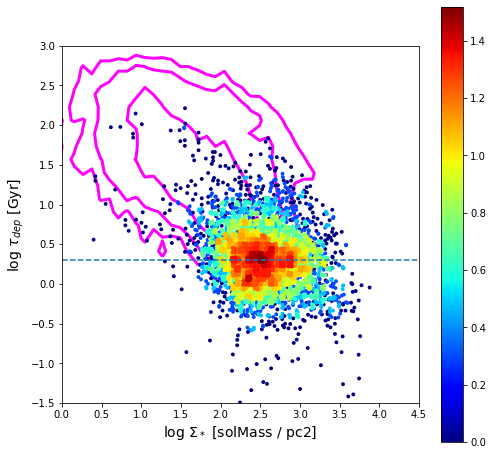

In [8]:
# Select data to plot (must be loggable)
not_nan = (~np.isnan(sig_star)) & (~np.isnan(t_dep)) & (sig_star>0) & (t_dep>0)
print('Excluding {} invalid values'.format(len(np.nonzero(~not_nan)[0])))
print('Number of valid points:',len(np.nonzero(not_nan)[0]))
not_nan_ndet = (~np.isnan(sig_star_ndet)) & (~np.isnan(t_dep_ndet)) & (sig_star_ndet>0) & (t_dep_ndet>0)

x_det, y_det, z_det, *hist = xy2hist(sig_star[not_nan], t_dep[not_nan], log=True)
x_ndet, y_ndet, z_ndet, *hist2 = xy2hist(sig_star_ndet[not_nan_ndet], 
                                         t_dep_ndet[not_nan_ndet], log=True, bins=[50,50])

# Make the scatter plot
fig, ax = plt.subplots(figsize=(8,8))
cm = plt.cm.get_cmap('jet')
sc = ax.scatter(x_det, y_det, c=z_det, s=15, edgecolor='', cmap=cm)
ax.contour(hist2[0].transpose(),[10,30,100,300],
           extent=[hist2[1].min(),hist2[1].max(),
                   hist2[2].min(),hist2[2].max()],
           colors='magenta',linewidths=3,zorder=-1)
plt.xlabel(r'log $\Sigma_*$ ['+str(sig_star.unit)+']',fontsize=14)
plt.ylabel(r'log $\tau_{dep}$ ['+str(t_dep.unit)+']',fontsize=14)
ax.set_aspect('equal')
ax.axhline(0.3, linestyle='--')
ax.set_xlim(0,4.5)
ax.set_ylim(-1.5,3)
plt.colorbar(sc)

## Depletion time vs. local sSFR

Excluding 12 invalid values
Number of valid points: 5375


/opt/local/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:14: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated. Use an explicit list instead.
  


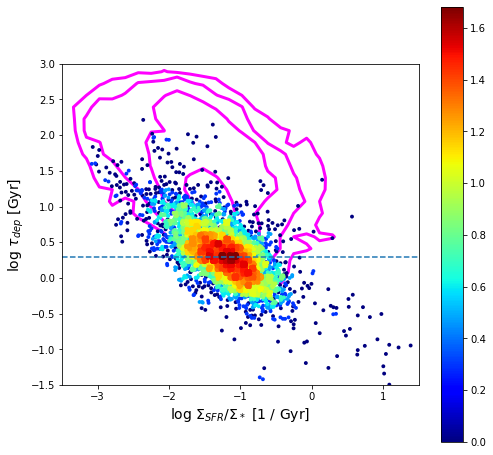

In [9]:
# Select data to plot (must be loggable)
not_nan = (np.isfinite(sig_ssfr)) & (np.isfinite(t_dep)) & (sig_ssfr>0) & (t_dep>0)
print('Excluding {} invalid values'.format(len(np.nonzero(~not_nan)[0])))
print('Number of valid points:',len(np.nonzero(not_nan)[0]))
not_nan_ndet = (np.isfinite(sig_ssfr_ndet)) & (np.isfinite(t_dep_ndet)) & (sig_ssfr_ndet>0) & (t_dep_ndet>0)

x_det, y_det, z_det, *hist = xy2hist(sig_ssfr[not_nan], t_dep[not_nan], log=True)
x_ndet, y_ndet, z_ndet, *hist2 = xy2hist(sig_ssfr_ndet[not_nan_ndet], 
                                         t_dep_ndet[not_nan_ndet], log=True, bins=[50,50])

# Make the scatter plot
fig, ax = plt.subplots(figsize=(8,8))
cm = plt.cm.get_cmap('jet')
sc = ax.scatter(x_det, y_det, c=z_det, s=15, edgecolor='', cmap=cm)
ax.contour(hist2[0].transpose(),[10,30,100,300],
           extent=[hist2[1].min(),hist2[1].max(),
                   hist2[2].min(),hist2[2].max()],
           colors='magenta',linewidths=3,zorder=-1)
plt.xlabel(r'log $\Sigma_{SFR}$/$\Sigma_*$ ['+str(sig_ssfr.unit)+']',fontsize=14)
plt.ylabel(r'log $\tau_{dep}$ ['+str(t_dep.unit)+']',fontsize=14)
ax.set_aspect('equal')
ax.axhline(0.3, linestyle='--')
ax.set_xlim(-3.5,1.5)
ax.set_ylim(-1.5,3)
plt.colorbar(sc)